This notebook takes an area of interest (Tampa Bay, FL) and a csv of water quality data (temperature). It starts by walking through how to fill that area of interest polygon with H3 Heaxagons of different sizes. It then walks through aggregating water quality data to a given scale of hexagons.

## Part 1: Area of Interest filled with different aperture hexagons

In [1]:
# Import all the required libraries
import os
import pandas
import numpy
import geopandas
import h3
import matplotlib.pyplot as plt
from shapely.geometry import shape, mapping

%matplotlib notebook

In [2]:
# All the required functions
def poly_hex_idx(gdf, aperture_size):
    """ Polygon to hex by fill (only 1 polygon at a time)"""
    hex_col = 'hex' + str(aperture_size)
    temp = mapping(gdf)  #shapely.mapping()
    temp_geo = temp['features'][0]['geometry']
    # Switch temp_geo x-y order and convert tuple to list
    temp_geo['coordinates'] = [[(j[1],j[0]) for j in geo] for geo in temp_geo['coordinates']]
    # Create dataframe for polygon filled with hexagons
    df_hex = pandas.DataFrame(h3.polyfill(temp_geo,
                                          aperture_size),
                              columns=[hex_col])

    return df_hex


def boundary_geom(hex_id):
    '''Implement h3_to_geo_boundary in bulk'''
    return shape({'type': 'Polygon',
                  'coordinates': [h3.h3_to_geo_boundary(h=hex_id,
                                                        geo_json=True)]})

Load Area of Interest (AOI) shapefile from temperature_data folder in current working directory.

In [3]:
data_dir = os.path.join(os.getcwd(), 'temperature_data')
# Original source:
shp_aoi = os.path.join(data_dir, 'TampaBay.shp')
gdf_aoi = geopandas.read_file(shp_aoi)

Create a geodataframe with the hexagon boundaries

In [4]:
# Set the desired aperture size (1-15)
aperture_size = 11
hex_col = 'hex' + str(aperture_size)
# Create data frame of hex ids of the set size that fill the aoi
aoi_hex_fill = poly_hex_idx(gdf_aoi, aperture_size)
# To map these hexagons they need planar coordinates
aoi_hex_fill['geom'] = aoi_hex_fill[hex_col].apply(lambda x: boundary_geom(x))
# The boundary coordinates can be used to create a geopandas dataframe
gdf_hex = geopandas.GeoDataFrame(aoi_hex_fill, geometry='geom')

Plot the Tampa polygon filled with hexagons

<IPython.core.display.Javascript object>


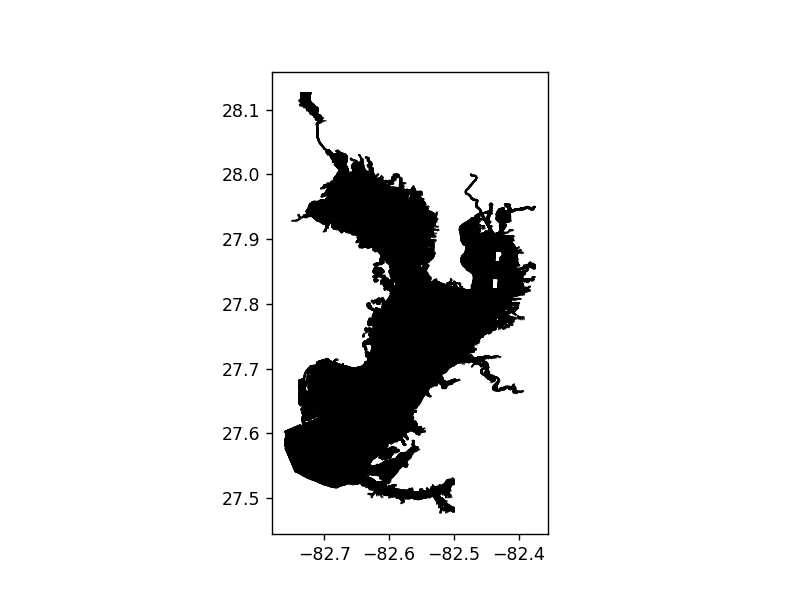

In [5]:
gdf_hex.plot(edgecolor='k')

<IPython.core.display.Javascript object>


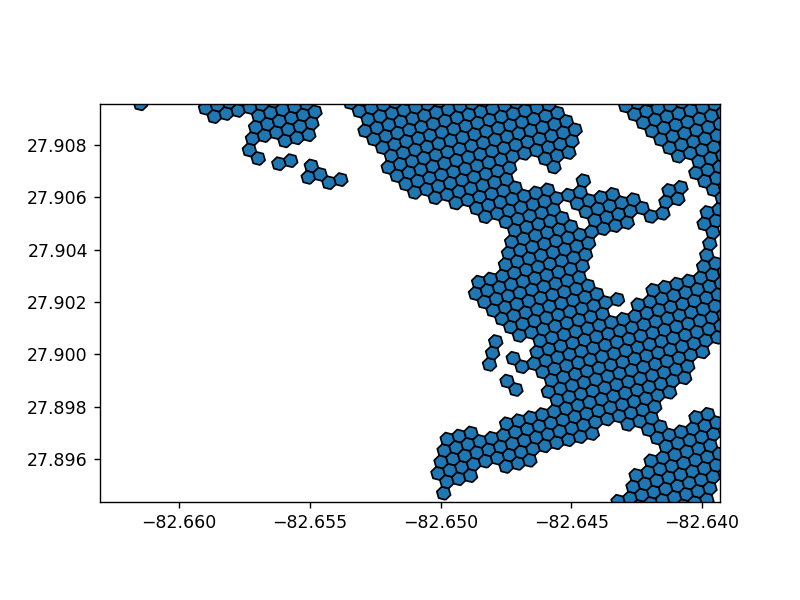

In [10]:
# Those small hexagons are hard so see so we'll zoom in on a small area
fig,ax = plt.subplots()
gdf_hex.plot(edgecolor='k', ax=ax)
# Set specific x/y limits
#minx, miny, maxx, maxy = [-82.68, 27.908, -82.67, 27.918]
#ax.set_xlim(minx, maxx)
#ax.set_ylim(miny, maxy)
#gdf_hex.plot(edgecolor='k', ax = ax)

In [7]:
# Geopandas can easily be saved as a shapefile
out_shp = os.path.join(data_dir, 'fill_{}.shp'.format(hex_col))
gdf_hex.to_file(out_shp)

## Part 2: Load the example point data (downloads as two parts: points shp and csv data)

In [8]:
# Functions for part #2
def datetime_combine(df, date_field, time_field, tz_field, datetime_field):
    """from USGS data retrieval (for NWIS)"""
    # Time zone converter dictionary
    tz_dict = {'EST': '-0500',
               'EDT': '-0400',
               numpy.nan: ''}
    df[tz_field] = df[tz_field].map(tz_dict)
    df[time_field] = df[time_field].fillna('00:00:00')
    
    
    # datetime formated
    df[datetime_field] = pandas.to_datetime(df.pop(date_field) + ' ' +
                                            df.pop(time_field) + ' ' +
                                            df.pop(tz_field),
                                            format='%Y-%m-%d %H:%M',
                                            utc=True)
    return df


def temp_F2C(temp_F):
    """Convert temperture from Fahrenheit to Celsius"""
    return (temp_F - 32.0) * 5.0 / 9.0


def convert_temperature(df, val_field, unit_field, new_field=False):
    """Convert temperature field to consistent degrees C
    if new_field specified dataframe updated inplace and old fields dropped
    if no new_field specified (default) returns series with converted values
    """
    unit_mask = df[unit_field] == 'deg F'
    if new_field:
        df[new_field] = df[val_field].mask(unit_mask, temp_F2C(df[val_field]))
        df.drop([val_field, unit_field], axis=1, inplace=True)
    else:
        return df[val_field].mask(unit_mask, temp_F2C(df[val_field]))


def wqp_stats(df, datetime_field, statReportType='daily', statTypeCd='mean'):
    """
    NWIS-like daily statistics funciton for waterquality portal
    
    Parameters:     
        statReportType (string): daily (default), monthly, or annual
        statTypeCd (string): all, mean, max, min, median
    
        Start and End will always be min/max timestamp in dataframe
    
    Returns:
        Dataframe of summary statistics
    """
    pd_freq = {'daily': 'D',
               'monthly': 'M',
               'annual': 'A'
               }
    if statReportType in pd_freq.keys():
        freq = pd_freq[statReportType]
    else:
        freq = statReportType
    
    # Loc_ID field to groupby (deal with depth later)
    df['Loc_ID'] = df.index

    # Resample by set increment
    if statTypeCd == 'all':
        #return all stats as multiple columns, loop over self call?
        return df
    elif statTypeCd == 'mean':
        return df.groupby('Loc_ID').resample(freq, on=datetime_field).mean()
    elif statTypeCd == 'max':
        return df.groupby('Loc_ID').resample(freq, on=datetime_field).max()
    elif statTypeCd == 'min':
        return df.groupby('Loc_ID').resample(freq, on=datetime_field).min()
    elif statTypeCd == 'median':
        return df.groupby('Loc_ID').resample(freq, on=datetime_field).median()


def hex_idx(gdf, aperture_size, method='count'):
    """ Point to hex by aggregating"""
    hex_col = 'hex' + str(aperture_size)
    # Assign hex ID
    gdf[hex_col] = gdf.apply(lambda x: h3.geo_to_h3(x.geometry.y,
                                                    x.geometry.x,
                                                    aperture_size), 1)
    # Aggregate into hexagons
    if method=='avg':
        df_hex = gdf.groupby(hex_col).mean()
    else:
        df_hex = gdf.groupby(hex_col).size().to_frame('cnt')
    return df_hex.reset_index()

In [9]:
# WQP station points shapefile
# From WQP: https://www.waterqualitydata.us/portal/ (see getWQP notebook for query)
shp_loc = os.path.join(data_dir, 'station_points_combined.shp')
gdf_loc = geopandas.read_file(shp_loc)  # Read to geodataframe
# Temperature results csv
csv_temp = os.path.join(data_dir, 'narrowresult.csv')
# Change Coordinate Reference System to match AOI if it doesn't already
if gdf_loc.crs != gdf_aoi.crs:
    gdf_aoi.to_crs(gdf_loc.crs.to_epsg(), inplace=True)
# Sample points are retrieved by extent, so clip it to the AOI polygon
gdf = geopandas.clip(gdf_loc, gdf_aoi)
gdf.drop(['Id'], axis=1, inplace=True)  # Drop 'Id' it's an empty field

Read the csv to a df, dropping empty fields

In [10]:
# Columns that are already in sample points table and not used for join
dup_cols = ['OrganizationIdentifier', 'OrganizationFormalName', 'ProviderName']
# Read csv to dataframe
df_temp = pandas.read_csv(csv_temp,
                          usecols=lambda x: x not in dup_cols,
                          low_memory=False)
# Drop missing data columns
df_temp.dropna(axis=1, how='all', inplace=True)

Parse date fields

In [11]:
df_temp = datetime_combine(df_temp,
                           'ActivityStartDate',
                           'ActivityStartTime/Time',
                           'ActivityStartTime/TimeZoneCode',
                           'Activity_datetime')
# drop '0001-01-01' from time stamps
analysis = 'AnalysisStartTime/Time'
df_temp[analysis] = [t[11:] if str(t).startswith('0001-01-01') else t
                     for t in df_temp[analysis]]
df_temp = datetime_combine(df_temp,
                           'AnalysisStartDate',
                           'AnalysisStartTime/Time',
                           'AnalysisStartTime/TimeZoneCode',
                           'Analysis_datetime')

Join sample points and temperature results on 'Loc_ID'

In [12]:
gdf_temp = gdf.set_index('Loc_ID').join(df_temp.set_index('MonitoringLocationIdentifier'))
#NOTE: if renamed so both are Loc_ID the index will have a name
gdf_temp.dropna(axis=1, how='all', inplace=True)  # Drop empty column again

Convert temperature results to consistent units

In [13]:
convert_temperature(gdf_temp,
                    'ResultMeasureValue',
                    'ResultMeasure/MeasureUnitCode',
                    'deg_c')

Datetime fields can be used to get specific periods of time and average across set increments (e.g. average daily value from hourly data) 

In [14]:
# Get annual averages
gdf_avg = wqp_stats(gdf_temp, 'Activity_datetime', statReportType='annual')
# Limit to 2011
gdf_avg.reset_index(inplace=True)
df_2011 = gdf_avg[gdf_avg['Activity_datetime']=='2011-12-31 00:00:00+00:00']
# Join back to geometry
gdf_2011 = gdf.set_index('Loc_ID').join(df_2011.set_index('Loc_ID'))

Convert point temperatures to hex

In [15]:
# Set the desired aperture size (1-15)
aperture_size = 11
hex_col = 'hex' + str(aperture_size)
# Values within one hex can be aggregated multiple ways
df_hex = hex_idx(gdf, aperture_size)  # Count - to get a count of data points
hex_2011 = hex_idx(gdf_2011, aperture_size,'avg')  # Average of temperature

Add geometry back to the dataframe to map it

In [16]:
df_hex['geom'] = df_hex[hex_col].apply(lambda x: boundary_geom(x))
gdf_hex = geopandas.GeoDataFrame(df_hex, geometry='geom')

hex_2011['geom'] = hex_2011[hex_col].apply(lambda x: boundary_geom(x))
gdf_2011_hex = geopandas.GeoDataFrame(hex_2011, geometry='geom')

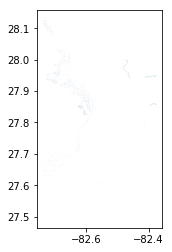

In [17]:
gdf_hex.plot()

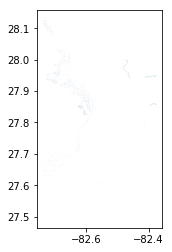

In [18]:
gdf_2011_hex.plot()

## Part 3: Interpolate areas where temperatures are missing

In [19]:
def kring_IDW(df, hex_col, metric_col, k_max):
    '''
    Uses hollow rings method, solid disks may be faster
    k_max is the number of rings out from a cell to consider
    '''
    df_agg = df[[hex_col]]
    df_agg['hexk'] = df_agg[hex_col]
    df_agg.set_index(hex_col,inplace=True)
    temp2 = [df_agg['hexk'].reset_index()]
    temp2[-1]['k'] = 0

    for k in range(1,k_max):
        temp2.append((df_agg['hexk']
                     .apply(lambda x: pandas.Series(list(h3.hex_ring(x,k)))).stack()
                     .to_frame('hexk').reset_index(1, drop=True).reset_index()
                ))
        temp2[-1]['k'] = k
    df_all = pandas.concat(temp2).merge(df)
    df_all.dropna(subset=[metric_col],inplace=True)  # Drop NaN
    # Instead of applying the coef, divide by k
    #df_all[metric_col] = df_all[metric_col] * df_all.k.apply(lambda x:coef[x])
    df_all['num_val'] = df_all[metric_col]/df_all.k  # if k=0, x/k = inf
    # sum numerator
    dfs_t = df_all.groupby('hexk')[['num_val']].sum()
    # sum denominator
    df_all['den_val'] = 1.0/df_all.k
    #nan -> inf so convert back and drop nan
    df_all['den_val'] = df_all['den_val'].replace(numpy.inf, numpy.nan)
    #df_all.dropna(subset=['num_val'],inplace=True)
    dfs_b = df_all.groupby('hexk')[['den_val']].sum()

    dfs = dfs_t.join(dfs_b)
    dfs['idw'] = dfs['num_val']/dfs['den_val']
    #reduce dfs
    dfs = dfs[['idw']]
    #fix index name
    dfs.index.rename(hex_col,inplace=True)
    #join back to df
    dfs = df.set_index(hex_col).join(dfs)
    #replace inf with orig?
    return dfs.reset_index()

In [20]:
# Create filled area (define where temperatures are wanted)
aoi_hex_fill = poly_hex_idx(gdf_aoi, aperture_size)
# Combine hex data and filled hex
df_all = aoi_hex_fill.set_index(hex_col).join(gdf_2011_hex.set_index(hex_col))
df_all.reset_index(inplace=True)
# Fill missing cells using IDW
df_2011_idw = kring_IDW(df_all, hex_col, metric_col='deg_c', k_max=20)
# Add geometry to hexagons to map
df_2011_idw['geom'] = df_2011_idw[hex_col].apply(lambda x: boundary_geom(x))
gdf_2011_idw = geopandas.GeoDataFrame(df_2011_idw, geometry='geom')

C:\ArcGIS\Local_GIS\Python\envs\arcgispro-py3-Hex_main2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [21]:
#check kring_IDW for something being done on a slice instead of the df